<a href="https://colab.research.google.com/github/AliciaFalconCaro/MedicalImageClassificationExample/blob/main/MedicalimageClassificationCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will perform some basic medical image classification techniques.
The purpose is to compare traditional techniques with DL techniques.

For this mini-project, we will use the public dataset available here: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic/data

The dataset is already separated in two folders: train and test. It contains multiple images from different skin cancers. In total, there are 6 classes of cancer in the dataset.

Let's start with loading the data and having a quick look at it

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = './local_dir/Skin_Cancer_ISIC_Data/Train'
test_dir = './local_dir/Skin_Cancer_ISIC_Data/Test'

batch_size=32

# Create ImageDataGenerator with rescaling and optional augmentation
#since we are using DL with CNN, no more propocessing steps are necessary. However, they could improve the accuracy/performance of the model
#we could use data augmentation or feature extraction techniques

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale/normalize pixel values to [0, 1]
    #You can add data augmentation here
    # rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    # shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
    validation_split=0.2 #let's separate training into training and validation (20% validation)
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and testing datasets
imageSize = (64, 64)  # Resize to 64x64

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=imageSize,  # Resize images to 64x64
    batch_size=32,
    class_mode='categorical',
    shuffle=True,  # Shuffle the dataset
    subset='training' # set as training data
    )

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=imageSize,  # Resize images to 64x64
    batch_size=32,
    class_mode='categorical',
    shuffle=True,  # Shuffle the dataset
    subset='validation' # set as training data
    )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=imageSize,  # Resize images to 64x64
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

# Get class names from the generator
class_names = train_generator.class_indices

print ("Class names:", class_names)
print ("Number of classes:", len(class_names))

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
Class names: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}
Number of classes: 9


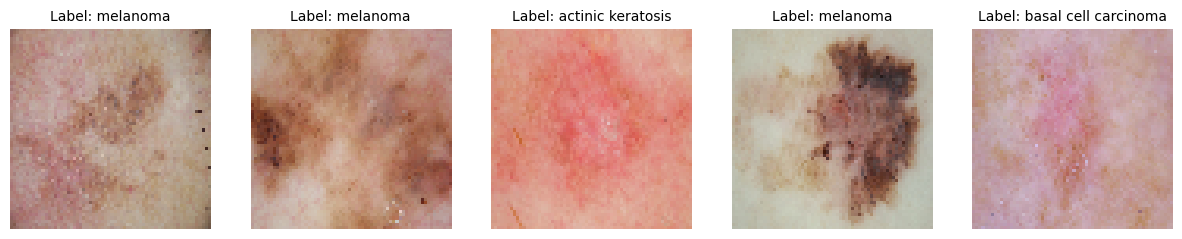

In [24]:
#Let's also see the first 5 images
import matplotlib.pyplot as plt
import numpy as np


def display_images(images, labels, le, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        ax.set_title(f"Label: {le.inverse_transform([label_index])[0]}", fontsize=10)
        ax.axis('off')
    plt.show()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(class_names.keys())) #so we can show the labels on each displayed image

images, labels = train_generator.__next__() #get first batch of data

display_images(images, labels, le)

<ipython-input-25-d7435dcefbbf>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(class_labels, rotation=45, ha='right') # Added this line to align labels


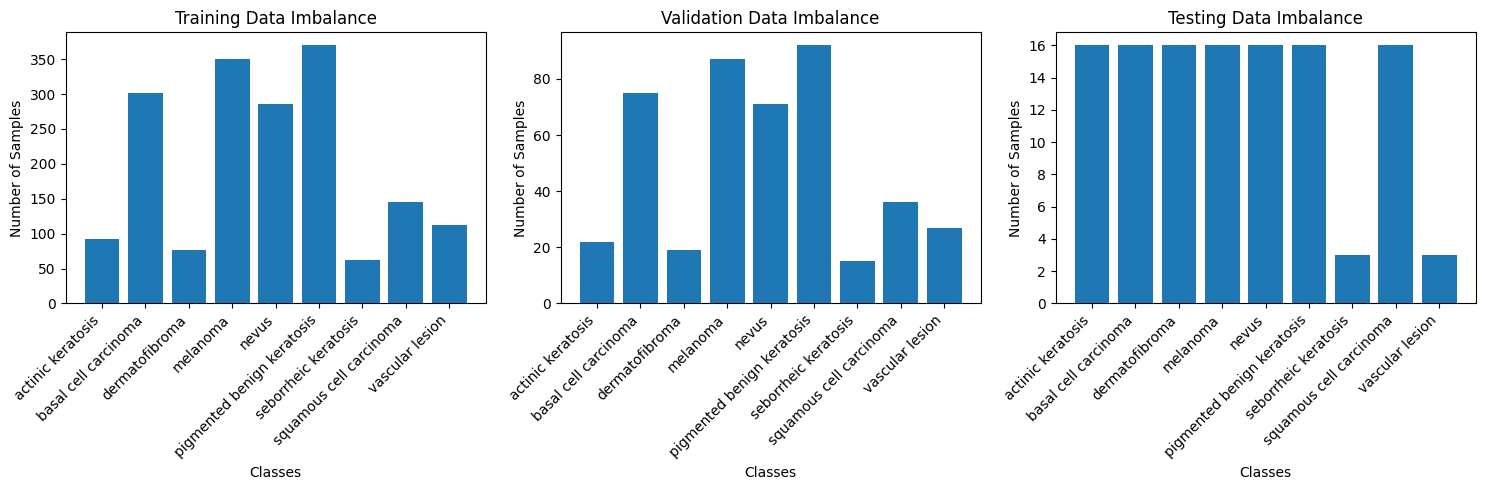

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data_imbalance(generators, titles):

    fig, axes = plt.subplots(1, len(generators), figsize=(15, 5))  # 1 row, 3 columns

    for i, (generator, title) in enumerate(zip(generators, titles)):
        class_counts = generator.classes
        class_labels = list(generator.class_indices.keys())
        count_per_class = np.bincount(class_counts)

        axes[i].bar(class_labels, count_per_class)
        axes[i].set_title(title)
        axes[i].set_xlabel('Classes')
        axes[i].set_ylabel('Number of Samples')
        # Rotate x-axis labels and align them to the right
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_xticklabels(class_labels, rotation=45, ha='right') # Added this line to align labels


    plt.tight_layout()
    plt.show()

# Visualize data imbalance using subplots
generators = [train_generator, val_generator, test_generator]
titles = ['Training Data Imbalance', 'Validation Data Imbalance', 'Testing Data Imbalance']
visualize_data_imbalance(generators, titles)

In [26]:
from tensorflow.keras import layers, models

# Define CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # labels are categorical
              metrics=['accuracy'])

# View model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 684,361 (2.61 MB)

 Trainable params: 684,361 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train the model
batch_size=32

TrainedModelCNN = model.fit(train_generator,validation_data=val_generator, epochs=50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 364ms/step - accuracy: 0.2117 - loss: 2.0930 - val_accuracy: 0.2252 - val_loss: 2.0945
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.2106 - loss: 1.9939 - val_accuracy: 0.2995 - val_loss: 1.9384
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.3744 - loss: 1.7264 - val_accuracy: 0.3063 - val_loss: 1.7753
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.4135 - loss: 1.6268 - val_accuracy: 0.3964 - val_loss: 1.6954
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.4683 - loss: 1.4768 - val_accuracy: 0.4009 - val_loss: 1.6286
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.4684 - loss: 1.4891 - val_accuracy: 0.3941 - val_loss: 1.7891
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.4941 - loss: 1.4060 - val_accuracy: 0.4414 - val_loss: 1.6805
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.4950 - loss: 1.4735 - val_accuracy: 0.405

In [28]:
#save trained model
model.save('TrainedModelCNN.keras') #can also be saved as tensorflow format instead

In [29]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.2188 - loss: 2.4885

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 973ms/step - accuracy: 0.2585 - loss: 3.0201
Test Accuracy: 0.31


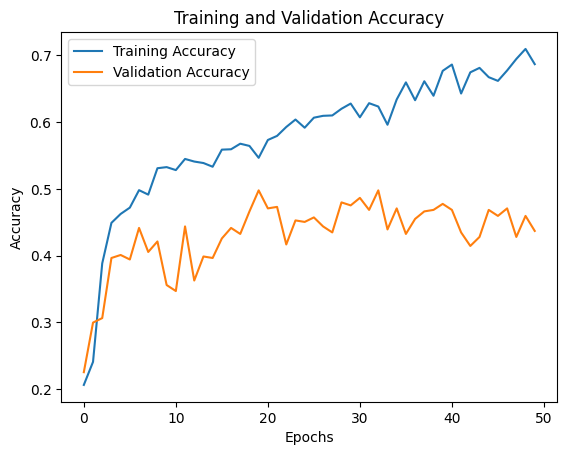

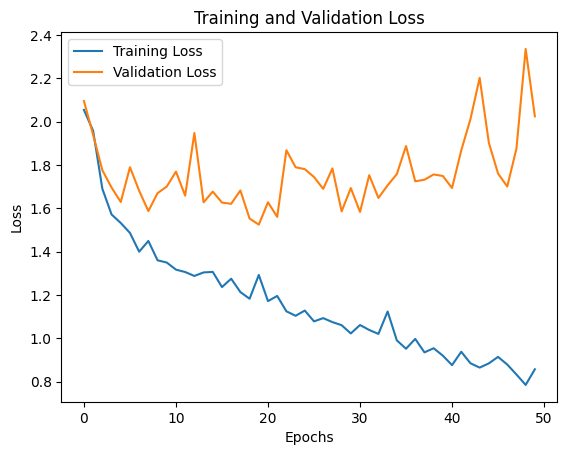

In [30]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(TrainedModelCNN.history['accuracy'], label='Training Accuracy')
plt.plot(TrainedModelCNN.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(TrainedModelCNN.history['loss'], label='Training Loss')
plt.plot(TrainedModelCNN.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


We visualise the results of the test data with a confusion matrix.

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions on the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
print(y_true)
print(y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 831ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 8 8 8]
[[1.28933031e-03 2.23571174e-02 6.39690086e-03 ... 3.23670089e-01
  1.18538935e-03 9.02936881e-06]
 [9.86944997e-07 2.14208078e-04 4.24853206e-05 ... 1.14178741e-02
  4.23988638e-07 1.80099280e-09]
 [3.39215323e-02 4.06541735e-01 3.68810110e-02 ... 7.67019017e-08
  1.11664394e-02 3.92520130e-02]
 ...
 [5.49465826e-15 1.12222285e-08 2.61078252e-17 ... 5.24471313e-25
  1.79037163e-15 9.99999046e-01]
 [4.06424142e-02 4.86630023e-01 2.98806936e-01 ... 2.15263444e-05
  5.34950872e-04 1.32893324e-01]
 [5.49587714e-15 3.54139416e-07 3.11156073e-10 ... 8.68976988e-24
  1.86152458e-13 9.99927163e-01]]


Text(0.5, 1.0, 'Confusion Matrix')

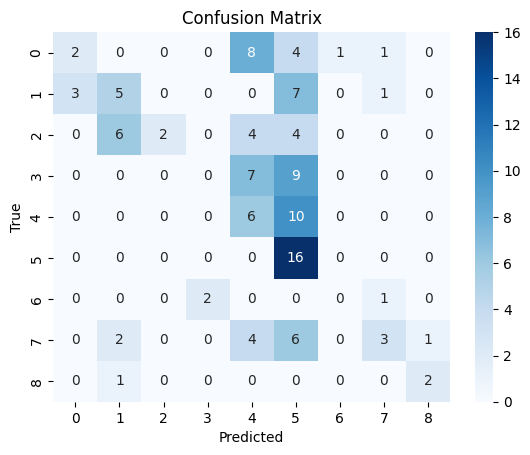

In [36]:
# Convert to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#Display the heatmap:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")

If we wanted a more detailed evaluation of the model performance, we could obtain and print the classification report:

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=class_names))


                            precision    recall  f1-score   support

         actinic keratosis       0.40      0.12      0.19        16
      basal cell carcinoma       0.36      0.31      0.33        16
            dermatofibroma       1.00      0.12      0.22        16
                  melanoma       0.00      0.00      0.00        16
                     nevus       0.21      0.38      0.27        16
pigmented benign keratosis       0.29      1.00      0.44        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.50      0.19      0.27        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.31       118
                 macro avg       0.38      0.31      0.27       118
              weighted avg       0.39      0.31      0.25       118

